# General E(2)-Equivariant Steerable CNNs  -  A concrete example


In [ ]:
import zipfile
import os

# Chemin du fichier ZIP
zip_path = '/content/e2cnn-master.zip'

# Dossier où extraire les fichiers
extract_to = '/content/'

# Vérifier si le fichier est un ZIP valide
if zipfile.is_zipfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extraire tout le contenu
        zip_ref.extractall(extract_to)
        print(f"Fichiers extraits dans {extract_to}")
else:
    print("Le fichier fourni n'est pas un fichier ZIP valide.")


Fichiers extraits dans /content/


In [ ]:
import os

# Chemin du répertoire interne
internal_path = '/content/e2cnn-master'

# Créer le répertoire s'il n'existe pas déjà
if not os.path.exists(internal_path):
    os.makedirs(internal_path)

# Changer le répertoire de travail
os.chdir(internal_path)

# Vérifier le nouveau répertoire courant
print("Répertoire courant :", os.getcwd())


Répertoire courant : /content/e2cnn-master


In [ ]:
import torch

from e2cnn import gspaces
from e2cnn import nn

Finally, we build a **Steerable CNN** and try it MNIST.

Let's also use a group a bit larger: we now build a model equivariant to $8$ rotations.
We indicate the group of $N$ discrete rotations as $C_N$, i.e. the **cyclic group** of order $N$.
In this case, we will use $C_8$.

Because the inputs are still gray-scale images, the input type of the model is again a *scalar field*.

However, internally we use *regular fields*: this is equivalent to a *group-equivariant convolutional neural network*.

Finally, we build *invariant* features for the final classification task by pooling over the group using *Group Pooling*.

The final classification is performed by a two fully connected layers.

# The model

Here is the definition of our model:

In [ ]:
class C8SteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10):

        super(C8SteerableCNN, self).__init__()

        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.Rot2dOnR2(N=8)

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(
            nn.MaskModule(in_type, 29, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)

        self.gpool = nn.GroupPooling(out_type)

        # number of output channels
        c = self.gpool.out_type.size

        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = nn.GeometricTensor(input, self.input_type)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)

        x = self.block5(x)
        x = self.block6(x)

        # pool over the spatial dimensions
        x = self.pool3(x)

        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

Let's try the model on *rotated* MNIST

In [ ]:
# download the dataset
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
# uncompress the zip file
!unzip -n mnist_rotation_new.zip -d mnist_rotation_new

File ‘mnist_rotation_new.zip’ already there; not retrieving.

Archive:  mnist_rotation_new.zip


In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose

import numpy as np

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'


Build the dataset

In [ ]:
class MnistRotDataset(Dataset):

    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']

        if mode == "train":
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"

        self.transform = transform

        data = np.loadtxt(file, delimiter=' ')

        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)

# images are padded to have shape 29x29.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(87)
resize2 = Resize(29)

totensor = ToTensor()

Let's build the model

In [ ]:
model = C8SteerableCNN().to(device)

The model is now randomly initialized.
Therefore, we do not expect it to produce the right class probabilities.

However, the model should still produce the same output for rotated versions of the same image.
This is true for rotations by multiples of $\frac{\pi}{2}$, but is only approximate for rotations by $\frac{\pi}{4}$.

Let's test it on a random test image:
we feed eight rotated versions of the first image in the test set and print the output logits of the model for each of them.

In [ ]:

def test_model(model: torch.nn.Module, x: Image):
    # evaluate the `model` on 8 rotated versions of the input image `x`
    model.eval()

    wrmup = model(torch.randn(1, 1, 29, 29).to(device))
    del wrmup

    x = resize1(pad(x))

    print()
    print('##########################################################################################')
    header = 'angle |  ' + '  '.join(["{:6d}".format(d) for d in range(10)])
    print(header)
    with torch.no_grad():
        for r in range(8):
            x_transformed = totensor(resize2(x.rotate(r*45., Image.BILINEAR))).reshape(1, 1, 29, 29)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()

            angle = r * 45
            print("{:5d} : {}".format(angle, y))
    print('##########################################################################################')
    print()



In [ ]:
# build the test set
raw_mnist_test = MnistRotDataset(mode='test')

In [ ]:
# retrieve the first image from the test set
x, y = next(iter(raw_mnist_test))

# evaluate the model
test_model(model, x)


##########################################################################################
angle |       0       1       2       3       4       5       6       7       8       9
    0 : [-0.2918  0.4869 -0.3093  0.4641  0.1835 -0.3956  0.1159 -0.0383 -0.2958  0.2991]
   45 : [-0.2963  0.4686 -0.3196  0.4396  0.1851 -0.3737  0.1208 -0.0083 -0.3102  0.2901]
   90 : [-0.2918  0.4869 -0.3093  0.4641  0.1835 -0.3956  0.116  -0.0383 -0.2958  0.2991]
  135 : [-0.2963  0.4686 -0.3196  0.4396  0.185  -0.3737  0.1208 -0.0082 -0.3102  0.2901]
  180 : [-0.2918  0.4869 -0.3093  0.4641  0.1835 -0.3956  0.1159 -0.0383 -0.2958  0.2991]
  225 : [-0.2963  0.4686 -0.3196  0.4396  0.185  -0.3737  0.1208 -0.0082 -0.3102  0.2901]
  270 : [-0.2918  0.4869 -0.3093  0.4641  0.1835 -0.3956  0.116  -0.0383 -0.2958  0.2991]
  315 : [-0.2963  0.4686 -0.3196  0.4396  0.1851 -0.3737  0.1208 -0.0082 -0.3102  0.2901]
##########################################################################################



The output of the model is already almost invariant.
However, we still observe small fluctuations in the outputs.

This is because the model contains some operations which might break equivariance.
For instance, every convolution includes a padding of $2$ pixels per side. This is adds information about the actual orientation of the grid where the image/feature map is sampled because the padding is not rotated with the image.

During training, the model will observe rotated patterns and will learn to ignore the noise coming from the padding.

So, let's train the model now.
The model is exactly the same used to train a normal *PyTorch* architecture:

In [ ]:
train_transform = Compose([
    pad,
    resize1,
    RandomRotation(180, interpolation=Image.BILINEAR, expand=False),
    resize2,
    totensor,
])

mnist_train = MnistRotDataset(mode='train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)


test_transform = Compose([
    pad,
    totensor,
])
mnist_test = MnistRotDataset(mode='test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

In [ ]:
import csv

# Création ou ouverture d'un fichier CSV
csv_file = "accuracy_log.csv"
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Test Accuracy"])  # En-tête du fichier

# Entraînement du modèle
for epoch in range(31):
    model.train()
    for i, (x, t) in enumerate(train_loader):

        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)

        loss = loss_function(y, t)

        loss.backward()

        optimizer.step()

    total = 0
    correct = 0
    with torch.no_grad():
        model.eval()
        for i, (x, t) in enumerate(test_loader):
            x = x.to(device)
            t = t.to(device)

            y = model(x)

            _, prediction = torch.max(y.data, 1)
            total += t.shape[0]
            correct += (prediction == t).sum().item()

    # Calcul de l'accuracy
    test_accuracy = correct / total * 100.0
    print(f"Epoch {epoch} | Test Accuracy: {test_accuracy:.2f}%")

    # Ajout des résultats au fichier CSV
    with open(csv_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, test_accuracy])


Epoch 0 | Test Accuracy: 92.34%
Epoch 1 | Test Accuracy: 94.17%
Epoch 2 | Test Accuracy: 95.11%
Epoch 3 | Test Accuracy: 95.02%
Epoch 4 | Test Accuracy: 95.58%
Epoch 5 | Test Accuracy: 95.95%
Epoch 6 | Test Accuracy: 96.21%
Epoch 7 | Test Accuracy: 96.47%
Epoch 8 | Test Accuracy: 96.99%
Epoch 9 | Test Accuracy: 96.90%
Epoch 10 | Test Accuracy: 97.30%
Epoch 11 | Test Accuracy: 97.32%
Epoch 12 | Test Accuracy: 97.33%
Epoch 13 | Test Accuracy: 97.40%
Epoch 14 | Test Accuracy: 97.53%
Epoch 15 | Test Accuracy: 97.69%
Epoch 16 | Test Accuracy: 97.68%
Epoch 17 | Test Accuracy: 97.66%
Epoch 18 | Test Accuracy: 97.63%
Epoch 19 | Test Accuracy: 97.49%
Epoch 20 | Test Accuracy: 97.55%
Epoch 21 | Test Accuracy: 97.37%
Epoch 22 | Test Accuracy: 97.32%
Epoch 23 | Test Accuracy: 97.24%
Epoch 24 | Test Accuracy: 97.41%
Epoch 25 | Test Accuracy: 97.20%
Epoch 26 | Test Accuracy: 96.48%
Epoch 27 | Test Accuracy: 97.35%
Epoch 28 | Test Accuracy: 97.36%
Epoch 29 | Test Accuracy: 97.50%
Epoch 30 | Test Accu

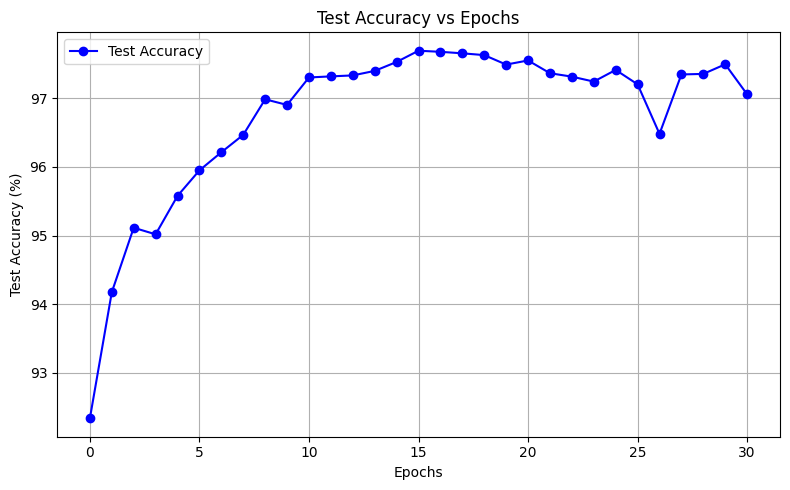

In [ ]:
import matplotlib.pyplot as plt

# Nom du fichier CSV
csv_file = "accuracy_log.csv"

# Listes pour stocker les données
epochs = []
test_accuracies = []

# Lecture des données du fichier CSV
with open(csv_file, mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Ignorer l'en-tête
    for row in reader:
        epochs.append(int(row[0]))  # Convertir l'époque en entier
        test_accuracies.append(float(row[1]))  # Convertir l'accuracy en float

# Tracé des données
plt.figure(figsize=(8, 5))
plt.plot(epochs, test_accuracies, marker="o", linestyle="-", color="b", label="Test Accuracy")
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# retrieve the first image from the test set
x, y = next(iter(raw_mnist_test))


# evaluate the model
test_model(model, x)


##########################################################################################
angle |       0       1       2       3       4       5       6       7       8       9
    0 : [-1.1767 -2.1905 -2.812  -0.8725 -2.043  -0.9892  9.7561 -0.8943 -2.1182 -1.7179]
   45 : [-1.4477 -2.7855 -2.6477 -1.3687 -2.2215 -1.2833  9.5301 -0.2551 -1.9389 -1.022 ]
   90 : [-1.1759 -2.1906 -2.8123 -0.8724 -2.042  -0.989   9.755  -0.8943 -2.1185 -1.7179]
  135 : [-1.4476 -2.7854 -2.6484 -1.3693 -2.2216 -1.2828  9.5296 -0.2531 -1.9384 -1.0223]
  180 : [-1.1765 -2.1906 -2.8124 -0.8722 -2.0431 -0.9899  9.7559 -0.8943 -2.1181 -1.7178]
  225 : [-1.4465 -2.785  -2.6478 -1.3692 -2.2222 -1.2819  9.5286 -0.2531 -1.9387 -1.0227]
  270 : [-1.1762 -2.1902 -2.8125 -0.8719 -2.0429 -0.9894  9.7554 -0.894  -2.1178 -1.7177]
  315 : [-1.4474 -2.7871 -2.647  -1.3698 -2.2207 -1.2828  9.5305 -0.2537 -1.9397 -1.0232]
##########################################################################################

